# Method 8 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

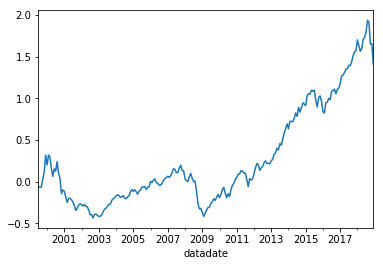

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.320666
2000-12-31   -0.317827
2001-12-31   -0.184151
2002-12-31   -0.192239
2003-12-31    0.357399
2004-12-31    0.122142
2005-12-31    0.038571
2006-12-31    0.114852
2007-12-31    0.080600
2008-12-31   -0.399882
2009-12-31    0.246354
2010-12-31    0.215193
2011-12-31    0.000112
2012-12-31    0.178856
2013-12-31    0.396801
2014-12-31    0.139618
2015-12-31    0.016282
2016-12-31    0.082180
2017-12-31    0.211363
2018-12-31   -0.061824
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     473.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.91e-109
Time:                        06:20:24   Log-Likelihood:                 637.69
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1248.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.503e-05      0.001      0.032      0.974      -0.002       0.002
mktrf          1.0086      0.030     33.735      0.000       0.950       1.067
me             0.2301      0.035      6.618      0.000       0.162       0.299
ia            -0.3660      0.053     -6.925      0.000      -0.470      -0.262
roe            0.1992      0.045      4.402      0.000       0.110       0.288
==============================================================================
Omnibus:                       43.210   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.147
Skew:                           0.012   Prob(JB):                    8.21e-108
Kurtosis:                      10.112   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     187.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.81e-71
Time:                        06:20:24   Log-Likelihood:                 637.69
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1248.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.503e-05      0.001      0.030      0.976      -0.002       0.002
mktrf          1.0086      0.038     26.653      0.000       0.934       1.083
me             0.2301      0.043      5.394      0.000       0.147       0.314
ia            -0.3660      0.123     -2.977      0.003      -0.607      -0.125
roe            0.1992      0.054      3.682      0.000       0.093       0.305
==============================================================================
Omnibus:                       43.210   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.147
Skew:                           0.012   Prob(JB):                    8.21e-108
Kurtosis:                      10.112   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     231.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.22e-79
Time:                        06:20:24   Log-Likelihood:                 637.69
No. Observations:                 234   AIC:                            -1265.
Df Residuals:                     229   BIC:                            -1248.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.503e-05      0.001      0.031      0.976      -0.002       0.002
mktrf          1.0086      0.038     26.782      0.000       0.935       1.082
me             0.2301      0.042      5.497      0.000       0.148       0.312
ia            -0.3660      0.116     -3.151      0.002      -0.594      -0.138
roe            0.1992      0.048      4.188      0.000       0.106       0.292
==============================================================================
Omnibus:                       43.210   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.147
Skew:                           0.012   Prob(JB):                    8.21e-108
Kurtosis:                      10.112   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     375.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.25e-108
Time:                        06:20:24   Log-Likelihood:                 637.34
No. Observations:                 234   AIC:                            -1263.
Df Residuals:                     228   BIC:                            -1242.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.684      0.495      -0.001       0.003
mktrf          0.9705      0.030     32.279      0.000       0.911       1.030
smb            0.2206      0.040      5.561      0.000       0.142       0.299
hml           -0.2028      0.047     -4.335      0.000      -0.295      -0.111
rmw            0.0561      0.053      1.061      0.290      -0.048       0.160
cma           -0.1366      0.067     -2.032      0.043      -0.269      -0.004
==============================================================================
Omnibus:                       42.736   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.646
Skew:                           0.022   Prob(JB):                    3.15e-104
Kurtosis:                       9.992   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     276.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.24e-94
Time:                        06:20:24   Log-Likelihood:                 637.34
No. Observations:                 234   AIC:                            -1263.
Df Residuals:                     228   BIC:                            -1242.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.815      0.415      -0.001       0.003
mktrf          0.9705      0.030     32.476      0.000       0.912       1.029
smb            0.2206      0.051      4.303      0.000       0.120       0.321
hml           -0.2028      0.048     -4.264      0.000      -0.296      -0.110
rmw            0.0561      0.071      0.793      0.428      -0.082       0.195
cma           -0.1366      0.146     -0.936      0.349      -0.423       0.149
==============================================================================
Omnibus:                       42.736   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.646
Skew:                           0.022   Prob(JB):                    3.15e-104
Kurtosis:                       9.992   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     394.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.38e-110
Time:                        06:20:24   Log-Likelihood:                 637.34
No. Observations:                 234   AIC:                            -1263.
Df Residuals:                     228   BIC:                            -1242.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.839      0.402      -0.001       0.003
mktrf          0.9705      0.030     31.932      0.000       0.911       1.030
smb            0.2206      0.045      4.863      0.000       0.132       0.310
hml           -0.2028      0.045     -4.535      0.000      -0.290      -0.115
rmw            0.0561      0.074      0.755      0.450      -0.090       0.202
cma           -0.1366      0.145     -0.940      0.347      -0.421       0.148
==============================================================================
Omnibus:                       42.736   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.646
Skew:                           0.022   Prob(JB):                    3.15e-104
Kurtosis:                       9.992   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     780.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.24e-132
Time:                        06:20:24   Log-Likelihood:                 691.04
No. Observations:                 234   AIC:                            -1372.
Df Residuals:                     229   BIC:                            -1355.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.663      0.508      -0.002       0.001
mktrf          1.0811      0.022     49.333      0.000       1.038       1.124
smb            0.1095      0.027      4.003      0.000       0.056       0.163
hml           -0.1528      0.027     -5.622      0.000      -0.206      -0.099
umd            0.2126      0.018     11.922      0.000       0.177       0.248
==============================================================================
Omnibus:                       28.025   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.720
Skew:                          -0.233   Prob(JB):                     2.50e-29
Kurtosis:                       6.646   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     638.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.02e-123
Time:                        06:20:24   Log-Likelihood:                 691.04
No. Observations:                 234   AIC:                            -1372.
Df Residuals:                     229   BIC:                            -1355.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.732      0.464      -0.002       0.001
mktrf          1.0811      0.042     25.715      0.000       0.999       1.164
smb            0.1095      0.033      3.277      0.001       0.044       0.175
hml           -0.1528      0.031     -4.998      0.000      -0.213      -0.093
umd            0.2126      0.037      5.726      0.000       0.140       0.285
==============================================================================
Omnibus:                       28.025   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.720
Skew:                          -0.233   Prob(JB):                     2.50e-29
Kurtosis:                       6.646   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     673.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.51e-125
Time:                        06:20:24   Log-Likelihood:                 691.04
No. Observations:                 234   AIC:                            -1372.
Df Residuals:                     229   BIC:                            -1355.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.691      0.490      -0.002       0.001
mktrf          1.0811      0.049     22.030      0.000       0.985       1.177
smb            0.1095      0.035      3.092      0.002       0.040       0.179
hml           -0.1528      0.030     -5.134      0.000      -0.211      -0.094
umd            0.2126      0.040      5.288      0.000       0.134       0.291
==============================================================================
Omnibus:                       28.025   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.720
Skew:                          -0.233   Prob(JB):                     2.50e-29
Kurtosis:                       6.646   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     196.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.91e-50
Time:                        06:20:24   Log-Likelihood:                 301.02
No. Observations:                 120   AIC:                            -592.0
Df Residuals:                     115   BIC:                            -578.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.769      0.444      -0.005       0.002
mktrf          1.0354      0.052     19.968      0.000       0.933       1.138
me             0.2721      0.051      5.312      0.000       0.171       0.374
ia            -0.4175      0.080     -5.206      0.000      -0.576      -0.259
roe            0.2691      0.071      3.790      0.000       0.128       0.410
==============================================================================
Omnibus:                       20.368   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.055
Skew:                           0.153   Prob(JB):                     2.08e-24
Kurtosis:                       7.660   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     67.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.55e-29
Time:                        06:20:24   Log-Likelihood:                 301.02
No. Observations:                 120   AIC:                            -592.0
Df Residuals:                     115   BIC:                            -578.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.714      0.475      -0.006       0.003
mktrf          1.0354      0.068     15.130      0.000       0.901       1.170
me             0.2721      0.051      5.283      0.000       0.171       0.373
ia            -0.4175      0.162     -2.570      0.010      -0.736      -0.099
roe            0.2691      0.061      4.423      0.000       0.150       0.388
==============================================================================
Omnibus:                       20.368   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.055
Skew:                           0.153   Prob(JB):                     2.08e-24
Kurtosis:                       7.660   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     68.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.68e-29
Time:                        06:20:24   Log-Likelihood:                 301.02
No. Observations:                 120   AIC:                            -592.0
Df Residuals:                     115   BIC:                            -578.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.745      0.456      -0.005       0.002
mktrf          1.0354      0.070     14.703      0.000       0.897       1.173
me             0.2721      0.052      5.235      0.000       0.170       0.374
ia            -0.4175      0.155     -2.689      0.007      -0.722      -0.113
roe            0.2691      0.044      6.092      0.000       0.182       0.356
==============================================================================
Omnibus:                       20.368   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.055
Skew:                           0.153   Prob(JB):                     2.08e-24
Kurtosis:                       7.660   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     144.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-47
Time:                        06:20:24   Log-Likelihood:                 297.04
No. Observations:                 120   AIC:                            -582.1
Df Residuals:                     114   BIC:                            -565.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.179      0.858      -0.004       0.004
mktrf          0.9727      0.057     17.135      0.000       0.860       1.085
smb            0.2518      0.064      3.916      0.000       0.124       0.379
hml           -0.2431      0.079     -3.086      0.003      -0.399      -0.087
rmw            0.0883      0.093      0.951      0.344      -0.096       0.272
cma           -0.1163      0.102     -1.142      0.256      -0.318       0.085
==============================================================================
Omnibus:                       17.965   Durbin-Watson:                   2.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.067
Skew:                          -0.000   Prob(JB):                     3.37e-19
Kurtosis:                       7.125   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     84.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.60e-37
Time:                        06:20:24   Log-Likelihood:                 297.04
No. Observations:                 120   AIC:                            -582.1
Df Residuals:                     114   BIC:                            -565.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.213      0.831      -0.003       0.004
mktrf          0.9727      0.056     17.308      0.000       0.863       1.083
smb            0.2518      0.069      3.631      0.000       0.116       0.388
hml           -0.2431      0.069     -3.512      0.000      -0.379      -0.107
rmw            0.0883      0.096      0.918      0.358      -0.100       0.277
cma           -0.1163      0.186     -0.624      0.533      -0.482       0.249
==============================================================================
Omnibus:                       17.965   Durbin-Watson:                   2.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.067
Skew:                          -0.000   Prob(JB):                     3.37e-19
Kurtosis:                       7.125   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     96.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.41e-39
Time:                        06:20:24   Log-Likelihood:                 297.04
No. Observations:                 120   AIC:                            -582.1
Df Residuals:                     114   BIC:                            -565.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.212      0.832      -0.003       0.004
mktrf          0.9727      0.058     16.808      0.000       0.859       1.086
smb            0.2518      0.060      4.214      0.000       0.135       0.369
hml           -0.2431      0.061     -3.970      0.000      -0.363      -0.123
rmw            0.0883      0.089      0.990      0.322      -0.087       0.263
cma           -0.1163      0.184     -0.631      0.528      -0.478       0.245
==============================================================================
Omnibus:                       17.965   Durbin-Watson:                   2.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.067
Skew:                          -0.000   Prob(JB):                     3.37e-19
Kurtosis:                       7.125   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     399.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.91e-66
Time:                        06:20:24   Log-Likelihood:                 339.53
No. Observations:                 120   AIC:                            -669.1
Df Residuals:                     115   BIC:                            -655.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.092      0.927      -0.003       0.003
mktrf          1.1437      0.033     34.509      0.000       1.078       1.209
smb            0.0767      0.038      2.034      0.044       0.002       0.151
hml           -0.1652      0.038     -4.370      0.000      -0.240      -0.090
umd            0.2601      0.023     11.164      0.000       0.214       0.306
==============================================================================
Omnibus:                       12.697   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               24.501
Skew:                          -0.404   Prob(JB):                     4.78e-06
Kurtosis:                       5.061   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     496.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-71
Time:                        06:20:24   Log-Likelihood:                 339.53
No. Observations:                 120   AIC:                            -669.1
Df Residuals:                     115   BIC:                            -655.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.123      0.902      -0.002       0.002
mktrf          1.1437      0.052     22.007      0.000       1.042       1.246
smb            0.0767      0.041      1.872      0.061      -0.004       0.157
hml           -0.1652      0.032     -5.229      0.000      -0.227      -0.103
umd            0.2601      0.041      6.302      0.000       0.179       0.341
==============================================================================
Omnibus:                       12.697   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               24.501
Skew:                          -0.404   Prob(JB):                     4.78e-06
Kurtosis:                       5.061   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     637.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.91e-77
Time:                        06:20:24   Log-Likelihood:                 339.53
No. Observations:                 120   AIC:                            -669.1
Df Residuals:                     115   BIC:                            -655.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.122      0.903      -0.002       0.002
mktrf          1.1437      0.059     19.483      0.000       1.029       1.259
smb            0.0767      0.045      1.691      0.091      -0.012       0.166
hml           -0.1652      0.030     -5.550      0.000      -0.223      -0.107
umd            0.2601      0.041      6.280      0.000       0.179       0.341
==============================================================================
Omnibus:                       12.697   Durbin-Watson:                   2.231
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               24.501
Skew:                          -0.404   Prob(JB):                     4.78e-06
Kurtosis:                       5.061   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     422.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.41e-65
Time:                        06:20:24   Log-Likelihood:                 368.88
No. Observations:                 114   AIC:                            -727.8
Df Residuals:                     109   BIC:                            -714.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.641      0.104      -0.000       0.004
mktrf          0.9893      0.029     34.576      0.000       0.933       1.046
me             0.1420      0.044      3.213      0.002       0.054       0.230
ia            -0.2446      0.061     -3.992      0.000      -0.366      -0.123
roe            0.0879      0.054      1.633      0.105      -0.019       0.195
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.492
Skew:                          -0.060   Prob(JB):                        0.782
Kurtosis:                       2.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     602.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.41e-73
Time:                        06:20:24   Log-Likelihood:                 368.88
No. Observations:                 114   AIC:                            -727.8
Df Residuals:                     109   BIC:                            -714.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.800      0.072      -0.000       0.003
mktrf          0.9893      0.025     40.046      0.000       0.941       1.038
me             0.1420      0.055      2.564      0.010       0.033       0.250
ia            -0.2446      0.053     -4.617      0.000      -0.348      -0.141
roe            0.0879      0.056      1.582      0.114      -0.021       0.197
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.492
Skew:                          -0.060   Prob(JB):                        0.782
Kurtosis:                       2.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     713.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.69e-77
Time:                        06:20:24   Log-Likelihood:                 368.88
No. Observations:                 114   AIC:                            -727.8
Df Residuals:                     109   BIC:                            -714.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.915      0.055   -3.72e-05       0.003
mktrf          0.9893      0.023     43.906      0.000       0.945       1.034
me             0.1420      0.055      2.589      0.010       0.035       0.249
ia            -0.2446      0.050     -4.907      0.000      -0.342      -0.147
roe            0.0879      0.051      1.711      0.087      -0.013       0.189
==============================================================================
Omnibus:                        0.323   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.492
Skew:                          -0.060   Prob(JB):                        0.782
Kurtosis:                       2.702   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     418.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.96e-69
Time:                        06:20:24   Log-Likelihood:                 380.92
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     108   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.856      0.394      -0.001       0.002
mktrf          0.9920      0.025     40.219      0.000       0.943       1.041
smb            0.1490      0.040      3.721      0.000       0.070       0.228
hml           -0.0810      0.051     -1.587      0.116      -0.182       0.020
rmw            0.0912      0.063      1.458      0.148      -0.033       0.215
cma           -0.2506      0.079     -3.156      0.002      -0.408      -0.093
==============================================================================
Omnibus:                        0.613   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.739
Skew:                           0.085   Prob(JB):                        0.691
Kurtosis:                       2.644   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1016.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.65e-89
Time:                        06:20:24   Log-Likelihood:                 380.92
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     108   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.098      0.272      -0.001       0.002
mktrf          0.9920      0.025     39.753      0.000       0.943       1.041
smb            0.1490      0.051      2.931      0.003       0.049       0.249
hml           -0.0810      0.051     -1.579      0.114      -0.182       0.020
rmw            0.0912      0.067      1.364      0.172      -0.040       0.222
cma           -0.2506      0.048     -5.227      0.000      -0.345      -0.157
==============================================================================
Omnibus:                        0.613   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.739
Skew:                           0.085   Prob(JB):                        0.691
Kurtosis:                       2.644   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     2168.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.47e-106
Time:                        06:20:24   Log-Likelihood:                 380.92
No. Observations:                 114   AIC:                            -749.8
Df Residuals:                     108   BIC:                            -733.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.152      0.249      -0.001       0.002
mktrf          0.9920      0.026     38.529      0.000       0.942       1.043
smb            0.1490      0.051      2.936      0.003       0.050       0.248
hml           -0.0810      0.044     -1.845      0.065      -0.167       0.005
rmw            0.0912      0.076      1.199      0.230      -0.058       0.240
cma           -0.2506      0.041     -6.084      0.000      -0.331      -0.170
==============================================================================
Omnibus:                        0.613   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.736   Jarque-Bera (JB):                0.739
Skew:                           0.085   Prob(JB):                        0.691
Kurtosis:                       2.644   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     497.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.17e-69
Time:                        06:20:24   Log-Likelihood:                 377.72
No. Observations:                 114   AIC:                            -745.4
Df Residuals:                     109   BIC:                            -731.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.373      0.710      -0.001       0.002
mktrf          1.0012      0.025     39.905      0.000       0.952       1.051
smb            0.1284      0.039      3.281      0.001       0.051       0.206
hml           -0.1518      0.040     -3.767      0.000      -0.232      -0.072
umd            0.0623      0.030      2.048      0.043       0.002       0.123
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.392
Skew:                           0.046   Prob(JB):                        0.822
Kurtosis:                       2.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     2415.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.13e-105
Time:                        06:20:24   Log-Likelihood:                 377.72
No. Observations:                 114   AIC:                            -745.4
Df Residuals:                     109   BIC:                            -731.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.467      0.640      -0.001       0.002
mktrf          1.0012      0.025     40.193      0.000       0.952       1.050
smb            0.1284      0.048      2.670      0.008       0.034       0.223
hml           -0.1518      0.041     -3.715      0.000      -0.232      -0.072
umd            0.0623      0.032      1.971      0.049       0.000       0.124
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.392
Skew:                           0.046   Prob(JB):                        0.822
Kurtosis:                       2.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     4448.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.00e-119
Time:                        06:20:24   Log-Likelihood:                 377.72
No. Observations:                 114   AIC:                            -745.4
Df Residuals:                     109   BIC:                            -731.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.481      0.630      -0.001       0.002
mktrf          1.0012      0.022     45.768      0.000       0.958       1.044
smb            0.1284      0.047      2.754      0.006       0.037       0.220
hml           -0.1518      0.035     -4.298      0.000      -0.221      -0.083
umd            0.0623      0.031      2.017      0.044       0.002       0.123
==============================================================================
Omnibus:                        0.218   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.392
Skew:                           0.046   Prob(JB):                        0.822
Kurtosis:                       2.728   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""